# TP 10 : Les réseaux de neurones


In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from matplotlib import colors
%matplotlib inline


## I- Réalisation d'un RN

On va utiliser cet exemple pour vérifier la réalisation
![exemple](RNPA-exp.png)

### I-1- Les fonctions d'activation

In [4]:
# TODO réaliser la dérivée de la fonction d'activation logistique
def logistique_deriver(Z, A): 
    return A * (1 - A)

# API
class Activation(object): 
    # Calculer l'activation en se basant sur Z (la somme linéaire)
    def activer(self, Z):
        pass
    # Calculer la dérivée en se basant sur Z et l'activation A
    def deriver(self, Z, A):
        pass
    
class Logistique(Activation):
    def activer(self, Z):
        return 1 / (1 + np.exp(-Z))
    def deriver(self, Z, A):
        return logistique_deriver(Z, A)

logistique = Logistique()

# ============================================
# ================= TEST =====================
# ============================================

z4_1 = np.array([1.666, 1.68])
a4_1 = logistique.activer(z4_1)
a4_1p = logistique.deriver(z4_1, a4_1)

#Résultat : 
# (array([0.84104179, 0.84290453]), array([0.1336905 , 0.13241648]))
a4_1, a4_1p

(array([0.84104179, 0.84290453]), array([0.1336905 , 0.13241648]))

### I-2- Les fonction du coût


In [5]:
# TODO réaliser la dérivée de la fonction d'erreur BCE
def BCE_deriver(H, Y):
    return (H - Y) / (H - H ** 2)

# API
class Cout(object): 
    # Calculer l'activation en se basant sur Z (la somme linéaire)
    def calculer(self, H, Y):
        pass
    # Calculer la dérivée en se basant sur Z et l'activation A
    def deriver(self, H, Y):
        pass

class BCE(Cout):
    def calculer(self, H, Y):
        return - (Y * np.log(H) + (1-Y) * np.log(1-H))
    def deriver(self, H, Y):
        return BCE_deriver(H, Y)
    
bce = BCE()

# ============================================
# ================= TEST =====================
# ============================================

H = np.array([0.840 , 0.843])
Y = np.array([0., 1.])
J = bce.calculer(H, Y)
DJ = bce.deriver(H, Y)

#Résultat : 
# (array([1.83258146, 0.17078832]), array([ 6.25      , -1.18623962]))
J, DJ

(array([1.83258146, 0.17078832]), array([ 6.25      , -1.18623962]))

### I-3- Le neurone

La fonction qui met à jour les paramètres prend en entrée : 
- $W$ une liste des poids; un vecteur de taille $Lp$ (le nombre des neurones de la couche précédente)
- $b$ le biais 
- $z$ la combinaison linéaire du neurone courant; un vecteur de taille $M$ (le nombre des échantillons)
- $a$ l'activation du neurone courant; un vecteur de taille $M$  
- $a\_past$ les activations des neurones de la couche précédente; une matrice de taille est $(M * Lp)$
- $delta\_next$ le delta calculé dans la couche suivante; une matrice de taille $M * Ln$ ($Ln$ : le nombre des neurones dans la couche suivante)
- $w\_next$ les poids vers la couche suivante; un vecteur de taille $Ln$
- $act$ c'est un object de type "Activation"; il fournit deux méthodes : "act.activer" et "act.deriver"
- $alpha$ le pas de l'entraînement 

In [6]:
# TODO compléter la fonction de mise à jours des poids d'un neurone
def neurone_maj(W, b, z, a, a_past, delta_next, w_next, act, alpha=1.):
    delta = np.multiply(np.dot(delta_next,w_next), act.deriver(z,a))
    #dW = np.mean(np.dot(delta, a_past),axis=0)
    #db = np.mean(delta,axis=0)
    m = len(z)
    dW = (1/m) * np.dot(delta, a_past)
    db = (1/m) * np.sum(delta)
    W = W - alpha * dW
    b = b - alpha * db
    return W, b, delta

# ============================================
# ================= TEST =====================
# ============================================

W = np.array([0.5, 0.2])
b = -0.3
z = np.array([0.5, 2.2])
# M (l'activation actuelle)
a = np.array([0.62245933, 0.90024951])
# M * L (les activations de la couche précédente)
a_past = np.array([[2., -1.], [3., 5.]])
# L
delta_next = np.array([[ 0.14523862, -0.02613822], [ 0.1394202, -0.02531591]]).T
w_next = np.array([0.3, -0.1])
act = logistique #la fonction d'activation


W_nouv, b_nouv, delta_nouv = neurone_maj(W, b, z, a, a_past, delta_next, w_next, act, alpha=1.)

# Résultat 
# (array([0.49375218, 0.2046736 ]),
#  -0.30324311474187016,
#  array([ 0.00696306, -0.00047683]))
W_nouv, b_nouv, delta_nouv

(array([0.49375218, 0.2046736 ]),
 -0.30324311474187016,
 array([ 0.00696306, -0.00047683]))

In [7]:


class Neurone(object):
    def __init__(self, taille_entree, activation=logistique):
        self.b = 0.
        self.w = np.array([0.] * taille_entree)
        self.activation = activation
        
    def randomiser(self):
        self.w = np.random.rand(len(self.w))
        self.b = np.random.rand(1)[0]
        
    def __aggreger(self, X):
        return np.dot(X, self.w) + self.b
    
    def activer(self, X):
        self.a_past = X
        self.z = self.__aggreger(X)
        self.a = self.activation.activer(self.z)
        return self.a
    
    def actualiser(self, delta_next, w_next, alpha=1.):
        w_ancien = self.w.copy()
        self.w, self.b, delta = neurone_maj(self.w, self.b, self.z, self.a, self.a_past, 
                                            delta_next, w_next, self.activation, alpha=alpha)
        return delta, w_ancien


# ============================================
# ================= TEST =====================
# ============================================

# M X L
a1 = np.array([[2., -1.], [3., 5.]])
# L
delta3 = np.array([[ 0.14523862, -0.02613822], [ 0.1394202, -0.02531591]]).T
w3_1 = np.array([0.3, -0.1])

n = Neurone(2)
#On ne doit pas affecter les poids directement 
#Ici, c'est juste pour avoir les mêmes poids du neurone de sortie dans l'exemple du cours
n.b = -0.3
n.w = np.array([0.5, 0.2])


a2_1 = n.activer(a1)
print("z2_1 = " + str(n.z))
print("a2_1 = " + str(a2_1))

# la dérivée de la fonction logistique n'a pas besoin de z, donc on passe 0
print("derivee(a2_1) = " + str(logistique.deriver(0,a2_1)))

print("ancien b = " + str(n.b))

delta2, w2_ancien = n.actualiser(delta3, w3_1) 

print("ancien w = " + str(w2_ancien))

print("delta2 = " + str(delta2))

print("nouveaux b = " + str(n.b))
print("nouveaux w = " + str(n.w))

# Résultat 
# z2_1 = [0.5 2.2]
# a2_1 = [0.62245933 0.90024951]
# derivee(a2_1) = [0.23500371 0.08980033]
# ancien b = -0.3
# ancien w = [0.5 0.2]
# delta2 = [ 0.00696306 -0.00047683]
# nouveaux b = -0.30324311473938026
# nouveaux w = [0.49375218 0.2046736 ]

z2_1 = [0.5 2.2]
a2_1 = [0.62245933 0.90024951]
derivee(a2_1) = [0.23500371 0.08980033]
ancien b = -0.3
ancien w = [0.5 0.2]
delta2 = [ 0.00696306 -0.00047683]
nouveaux b = -0.30324311473938026
nouveaux w = [0.49375218 0.2046736 ]


### I-4- La couche

In [8]:
class Couche(object):
    
    def __init__(self, taille, taille_entree, activation=logistique):
        self.neurones = [Neurone(taille_entree, activation=activation) for i in range(taille)]
        
    def randomiser(self):
        for neurone in self.neurones:
            neurone.randomiser()

    def propagation_avant(self, X):
        activations = []
        for neurone in self.neurones:
            activations.append(neurone.activer(X))
        return np.array(activations).T
    
    def retro_propagation(self, delta_next, W_next, alpha=1.):
        W_anciens = []
        Deltas = []
        for i, neurone in enumerate(self.neurones):
            delta, w_ancien = neurone.actualiser(delta_next, W_next[i], alpha=alpha)
            W_anciens.append(w_ancien)
            Deltas.append(delta)
        return np.array(Deltas).T, np.array(W_anciens).T


# ============================================
# ================= TEST =====================
# ============================================

a2 = np.array([[2., -1.], [3., 5.]])
# L
delta3 = np.array([[ 0.14523862, -0.02613822], [ 0.1394202, -0.02531591]]).T
w3 = np.array([[0.3, -0.1],[0.5, -0.3]])

c2 = Couche(2, 2)
#On ne doit pas affecter les poids directement 
#Ici, c'est juste pour avoir les mêmes poids du neurone de sortie dans l'exemple du cours
c2.neurones[0].b = -0.3
c2.neurones[0].w = np.array([0.5, 0.2])
c2.neurones[1].b = 0.5
c2.neurones[1].w = np.array([0.3, 0.4])

a2 = c2.propagation_avant(a1)
print("activations : " + str(a2))

Deltas2, W_anciens2 = c2.retro_propagation(delta3, w3)

print("deltas : " + str(Deltas2))

# Résultat : 
# activations : [[0.62245933 0.66818777]
#  [0.90024951 0.96770454]]
# deltas : [[ 0.00696306  0.00682726]
#  [-0.00047683 -0.00017109]]

activations : [[0.62245933 0.66818777]
 [0.90024951 0.96770454]]
deltas : [[ 0.00696306  0.00682726]
 [-0.00047683 -0.00017109]]


### I-5- Le réseau

In [9]:
class RN(object):
    def __init__(self, taille_entree, cout=bce, alpha=1.):
        self.taille_courante = taille_entree #la taille de la dernière couche
        self.cout = cout #objet de type Cout pour calculer le cout et sa dérivée
        self.alpha = alpha
        self.couches = []

    def ajouter_couche(self, taille, activation=logistique):
        nouv_couche = Couche(taille, self.taille_courante, activation=activation)
        self.couches.append(nouv_couche)
        self.taille_courante = taille
        
    def randomiser(self):
        for couche in self.couches:
            couche.randomiser()
    
    def predire(self, X): 
        Y = X
        if self.norm:
            Y = np.where(self.std==0, X, (X - self.mean)/self.std)
            
        for couche in self.couches:
            Y = couche.propagation_avant(Y)
        if Y.ndim == 2 and Y.shape[1] == 1:
            Y = Y.flatten()
        return np.where(Y < 0.5, 0, 1)
    
    
    def _faire_iteration(self, X, Y):
        # propagation avant
        a = X
        for couche in self.couches:
            a = couche.propagation_avant(a)
            
        # calcul du cout et sa dérivée 
        YY = np.array(Y)
        if YY.ndim < 2 : 
            YY = YY[:, np.newaxis]
        J = np.mean(self.cout.calculer(a, YY))
        J_prime = self.cout.deriver(a, YY)
        
        # retropropagation 
        w_past = np.array([[1.] * self.taille_courante])
        delta_past = J_prime
#         l = 5
        for couche in reversed(self.couches): # on commance de la dernière couche vers la première
#             print(l)
#             print(delta_past)
#             print(w_past)
#             l = l - 1
            delta_past, w_past = couche.retro_propagation(delta_past, w_past)
        return J
    
    def entrainer(self, X, Y, nbr_it=100, norm=False):
        couts = []
        X_norm = X
        self.norm = norm
        if norm:
            self.mean = np.mean(X, axis=0)
            self.std = np.std(X, axis=0)
            X_norm = np.where(self.std==0, X, (X - self.mean)/self.std)

        for i in range(nbr_it): 
            J = self._faire_iteration(X_norm, Y)
            couts.append(J)
        return couts
    
# ============================================
# ================= TEST =====================
# ============================================

X = np.array([[2., -1.], [3., 5.]])
Y = np.array([0., 1.])

rn = RN(2) #deux caractéristiques d'entrée
rn.ajouter_couche(2) #ajouter une couche avec 2 neurones (cachée)
rn.ajouter_couche(2) #ajouter une couche avec 2 neurones (cachée)
rn.ajouter_couche(1) #ajouter une couche avec 1 neurone (sortie)

#On ne doit pas affecter les poids directement 
#Ici, c'est juste pour avoir les mêmes poids du neurone de sortie dans l'exemple du cours
rn.couches[0].neurones[0].b = -0.3
rn.couches[0].neurones[0].w = np.array([0.5, 0.2])
rn.couches[0].neurones[1].b = 0.5
rn.couches[0].neurones[1].w = np.array([0.3, 0.4])

rn.couches[1].neurones[0].b = -0.3
rn.couches[1].neurones[0].w = np.array([0.3, 0.5])
rn.couches[1].neurones[1].b = -0.2
rn.couches[1].neurones[1].w = np.array([-0.1, -0.3])

rn.couches[2].neurones[0].b = 1.
rn.couches[2].neurones[0].w = np.array([0.7, 0.7])

J = rn._faire_iteration(X, Y)

print("le cout = " + str(J))
print("w4_1 = " + str(rn.couches[2].neurones[0].w))
print("w3_1 = " + str(rn.couches[1].neurones[0].w))
print("w3_2 = " + str(rn.couches[1].neurones[1].w))
print("w2_1 = " + str(rn.couches[0].neurones[0].w))
print("w2_2 = " + str(rn.couches[0].neurones[1].w))

rn.entrainer(X, Y, nbr_it=200)
print("la prédiction : " + str(rn.predire(X)))

# Résultat 
# le cout = 1.0020916974430965
# w4_1 = [0.51494626 0.56592079]
# w3_1 = [0.2665629 0.4641237]
# w3_2 = [-0.13199638 -0.33433028]
# w2_1 = [0.49375219 0.2046736 ]
# w2_2 = [0.29342937 0.40384135]
# la prédiction : [0 1]

le cout = 1.0020916974430962
w4_1 = [0.51494626 0.56592079]
w3_1 = [0.2665629 0.4641237]
w3_2 = [-0.13199638 -0.33433028]
w2_1 = [0.49375219 0.2046736 ]
w2_2 = [0.29342937 0.40384135]
la prédiction : [0 1]


### I-6- Application sur une exemple

On va utiliser le dataset [Diabetics prediction using logistic regression](https://www.kaggle.com/kandij/diabetes-dataset). 

In [10]:
# diabetes2
diabetes = pd.read_csv("datasets/diabetes2.csv") 
X_diabetes = diabetes.iloc[:, :-1].values  
Y_diabetes = diabetes.iloc[:, -1].values

# Cette configuration est mise en place comme ceci exprès
# C'est pour tester le cas où la régression est difavorisée
NBR_TEST = 240
# Supposant que les 30% premières lignes sont pour le test et le reste pour l'entraînement
X_test = X_diabetes[-NBR_TEST:, :] # 30% ou plus
Y_test = Y_diabetes[-NBR_TEST:]

X_train = X_diabetes[:-NBR_TEST, :] 
Y_train = Y_diabetes[:-NBR_TEST]

diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


#### I-6-1- Randomisation des paramètres (thétas)

On va créer 4 modèles :
1. deux couches cachées avec 4 et 2 neurones respectivement et des paramètres mis à zéro
1. le même  que le précédent mais on affecte des valeurs aléatoires aux paramètres
1. une seule couche cachée avec 4 neurones et des paramètres mis à zéro

**Analyse**

On remarque que la fonction du coût ne change pas sa valeur lorsqu'on met les thétas à zéro, ce qui indique que les paramètres nne sont pas mis à jour. Pourquoi?
Pourtant, lorsqu'il y a une seule couche cachée, les paramètres sont bien mis à jour.

**Réponse**

En fait, toute initialisation constante fonctionnera très mal. Considérons un réseau de neurones avec deux unités cachées et supposons que nous initialisons tous les $b$ à 0 et les $W$ avec une constante $\alpha$. Si nous transmettons une entrée $(x_{1}, x_{2})$ dans ce réseau, la sortie des deux unités cachées sera $activation\_function(\alpha x_{1},\alpha x_{2})$ Ainsi, les deux unités cachées auront une influence identique sur le coût, ce qui conduira à des gradients identiques. Ainsi, les deux neurones évolueront symétriquement tout au long de l'entrainement, empêchant efficacement différents neurones d'apprendre des choses différentes.

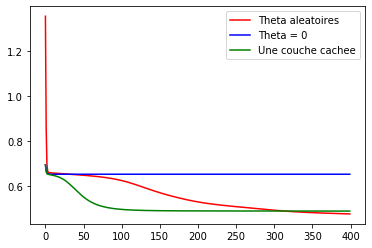

In [11]:
IT = 400

rn_norand = RN(8, alpha=0.1)
rn_norand.ajouter_couche(4) #ajouter une couche avec 4 neurones (cachée)
rn_norand.ajouter_couche(2) #ajouter une couche avec 2 neurones (cachée)
rn_norand.ajouter_couche(1) #ajouter une couche avec 1 neurone (sortie)

couts_norand = rn_norand.entrainer(X_train, Y_train, norm=True, nbr_it=IT)

rn_rand = RN(8, alpha=0.1)
rn_rand.ajouter_couche(4) #ajouter une couche avec 4 neurones (cachée)
rn_rand.ajouter_couche(2) #ajouter une couche avec 2 neurones (cachée)
rn_rand.ajouter_couche(1) #ajouter une couche avec 1 neurone (sortie)
rn_rand.randomiser()

couts_rand = rn_rand.entrainer(X_train, Y_train, norm=True, nbr_it=IT)

rn_une = RN(8, alpha=0.1)
rn_une.ajouter_couche(4) #ajouter une couche avec 4 neurones (cachée)
rn_une.ajouter_couche(1) #ajouter une couche avec 1 neurone (sortie)
couts_une= rn_une.entrainer(X_train, Y_train, norm=True, nbr_it=IT)

plt.plot(couts_rand, color="red", label="Theta aleatoires")
plt.plot(couts_norand, color="blue", label="Theta = 0")
plt.plot(couts_une, color="green", label="Une couche cachee")
plt.legend()
plt.show()


#### I-6-2- Complexité du problème 

On veut tester l'impact du nombre des couches (et des neurones) sur la  convergence et le temps d'entraînement. 
Pour ce faire, on a proposer 4 architectures avec une couche de sortie d'un seul neurone : 
1. 3 couches cachées : 8 X 4 X 2 neurones
1. 2 couches cachées : 4 X 2 neurones
1. 1 couche cachée : 2 neurones
1. 0 couches cachées : pratiquement c'est de la  régression logistique

**Analyse**

- Que remarquez-vous ?
- Au delà de 2 couches (cas 3 couches), on constate que le modèle a arrêté à converger, comme le cas des paramètres initialisés à zéro. Pourquoi à votre avis ?
- Est-ce que ce problème est aussi complexe qu'on aura besoin de plusieurs couches cachées ?
- Dans ce problème, en comparant entre les deux architectures : 2 couches cachhées et la régression logistique, quelle est la meilleure et pourquoi ?

**Réponse**

- La regression logistique converge plus rapidement que les réseaux de neuronnes d'une et deux couches, le réseau de neuronne de 3 couches s'arrete de converger plus rapidement que les autres.
- Lorsque on dépasse 2 couches, on se rend compte que le modèle a arrêté de converger. Cela est du a l'erreur propagée qui décremente de couche en couche ,jusqu'a devenir presque nulle au niveau de la premiere couche cachee, dans ce cas le model n'apprendra plus des erreurs.
- Non, le programme n'est pas aussi complexe au point où une regression logistique est meilleure que les réseaux de neuronnes.
- La regression logistique est meileure pour ce problème vu qu'elle minimise le cot mieux que le réseau de neuronne à 2 couches et plus rapidement.

temps 3 couches cachees : 0.5830983000000174
temps 2 couches cachees : 0.28227359999999635
temps 1 couche cachee : 0.1671916999999894
temps regression logistique : 0.07110480000000052


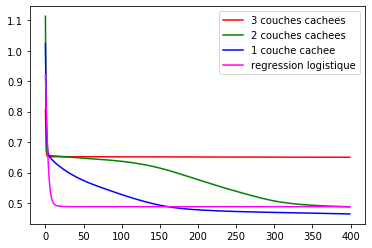

In [12]:
import timeit

IT = 400

rn1 = RN(8, alpha=0.1)
rn1.ajouter_couche(8) #ajouter une couche avec 4 neurones (cachée)
rn1.ajouter_couche(4) #ajouter une couche avec 4 neurones (cachée)
rn1.ajouter_couche(2) #ajouter une couche avec 2 neurones (cachée)
rn1.ajouter_couche(1) #ajouter une couche avec 1 neurone (sortie)
rn1.randomiser()

rn2 = RN(8, alpha=0.1)
rn2.ajouter_couche(4) #ajouter une couche avec 4 neurones (cachée)
rn2.ajouter_couche(2) #ajouter une couche avec 2 neurones (cachée)
rn2.ajouter_couche(1) #ajouter une couche avec 1 neurone (sortie)
rn2.randomiser()

rn3 = RN(8, alpha=0.1)
rn3.ajouter_couche(2) #ajouter une couche avec 2 neurones (cachée)
rn3.ajouter_couche(1) #ajouter une couche avec 1 neurone (sortie)
rn3.randomiser()

rn4 = RN(8, alpha=0.1)
rn4.ajouter_couche(1) #ajouter une couche avec 1 neurone (sortie)
rn4.randomiser()

temps_debut = timeit.default_timer()
couts1 = rn1.entrainer(X_train, Y_train, norm=True, nbr_it=IT)
temps1 = timeit.default_timer() - temps_debut

temps_debut = timeit.default_timer()
couts2 = rn2.entrainer(X_train, Y_train, norm=True, nbr_it=IT)
temps2 = timeit.default_timer() - temps_debut

temps_debut = timeit.default_timer()
couts3 = rn3.entrainer(X_train, Y_train, norm=True, nbr_it=IT)
temps3 = timeit.default_timer() - temps_debut

temps_debut = timeit.default_timer()
couts4 = rn4.entrainer(X_train, Y_train, norm=True, nbr_it=IT)
temps4 = timeit.default_timer() - temps_debut

print("temps 3 couches cachees : " + str(temps1))
print("temps 2 couches cachees : " + str(temps2))
print("temps 1 couche cachee : " + str(temps3))
print("temps regression logistique : " + str(temps4))

plt.plot(couts1, color="red", label="3 couches cachees")
plt.plot(couts2, color="green", label="2 couches cachees")
plt.plot(couts3, color="blue", label="1 couche cachee")
plt.plot(couts4, color="magenta", label="regression logistique")
plt.legend()
plt.show()


#### I-6-3- Performance

Ici, on veut tester les modèles en se basant sur la métrique "accuracy" et le temps de prédiction. 

**Analyse**

- Que remarquez-vous ?
- Pourquoi en augmentant le nombre des couches, le modèle prend plus de temps à prédire le résultat ? 

**Réponse**

- Pour ce problème la regression logistique présente la meilleure accuracy en un temps minimal et aussi lorsque le nombre de couche du réseau de neuronne augmente, l'accuracy diminue et le temps de prédiction augmente.
- Chaque couche qu'on ajoute à notre réseaux de neuronne, ce sont des opération en plus à calculer lors de la prédiction : On calcule d'abord le $Z$ en utilisant le $W$ et le $b$ de cette couche, et ensuite on lui applique la fonction d'activation pour avoir $A$


In [13]:
from sklearn.metrics import accuracy_score

temps_exec = []

temps_debut = timeit.default_timer()
Y1 = rn1.predire(X_test)
temps_exec.append(timeit.default_timer() - temps_debut)

temps_debut = timeit.default_timer()
Y2 = rn2.predire(X_test)
temps_exec.append(timeit.default_timer() - temps_debut)

temps_debut = timeit.default_timer()
Y3 = rn3.predire(X_test)
temps_exec.append(timeit.default_timer() - temps_debut)

temps_debut = timeit.default_timer()
Y4 = rn4.predire(X_test)
temps_exec.append(timeit.default_timer() - temps_debut)

accuracy = []

accuracy.append(accuracy_score(Y_test, Y1))
accuracy.append(accuracy_score(Y_test, Y2))
accuracy.append(accuracy_score(Y_test, Y3))
accuracy.append(accuracy_score(Y_test, Y4))

stat = pd.DataFrame({
    "architecture": ["3 couches cachees", "2 couches cachees", "1 couche cachee", "regression logistique"],
    "temps": temps_exec,
    "accuracy": accuracy
})

stat = stat.set_index(["architecture"])

stat

,temps,accuracy
architecture,,
3 couches cachees,0.001533,0.666667
2 couches cachees,0.001019,0.791667
1 couche cachee,0.000574,0.791667
regression logistique,0.000548,0.804167


## II- Amélioration d'un modèle

On va utiliser le dataset MNIST. 
Ici, on a utiliser seulement 100 échantillons pour l'entraînement (10 pour chaque chiffre) et 30 pour la validation (3 pour chaque chiffre). 
Donc, le modèle ne sera pas puissant ; c'est juste pour monter quelques applications dans le traitement d'images.

Le dataset contient des images de 28*28 pixels représentant des chiffres écrits manuellement. chaque pixel est un nombre entre 0 et 255.

(100, 28, 28, 1)
(30, 28, 28, 1)


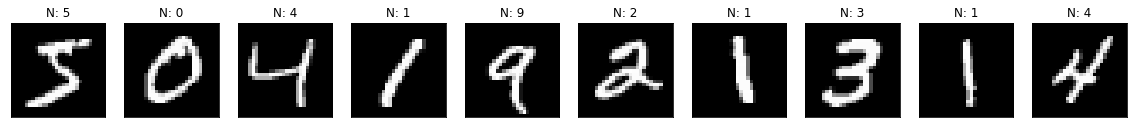

In [15]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.python.keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout, UpSampling2D
from tensorflow.python.keras.models import Sequential, Model

# cette instruction va télécharger la totalité du dataset
# mnist = tf.keras.datasets.mnist

#(x_train, y_train), (x_test, y_test) = mnist.load_data()

train = pd.read_csv("datasets/mnist_train.csv")
test = pd.read_csv("datasets/mnist_test.csv")

x_train = train.iloc[:, :-1].values # Premières colonnes 
y_train = train.iloc[:,-1].values # Dernière colonne 
x_test = test.iloc[:, :-1].values # Premières colonnes 
y_test = test.iloc[:,-1].values # Dernière colonne 

x_train = np.reshape(x_train, [-1, 28, 28, 1])
x_test = np.reshape(x_test, [-1, 28, 28, 1])
x_train, x_test = x_train / 255.0, x_test / 255.0

y_train_onehot = tf.keras.utils.to_categorical(y_train, 10)
y_test_onehot = tf.keras.utils.to_categorical(y_test, 10)

print(x_train.shape)
print(x_test.shape)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i].reshape(28, 28))
    plt.gray()
    plt.title("N: " + str(y_train[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### II-1- Classement des chiffres

Ici, on essaye d'entrainer un modèle qui reconnait les chiffres de 0 à 9. 
Il y a deux modèles : 
- Dans le première cellule, c'est une modèle basique (
- Dans la deuxième cellule, c'est un modèle identique au premier. Sauf, vous devez le changer en ajoutant des couches : Dropout, MaxPooling2D, etc. Le deuxième modèle doit être une amélioration. Vous devez discuter comment vous l'avez améliorer, c-à-d, si vous avez ajouter une autre couche, pourquoi ?

**Amélioration**

Le modèle a deux aspects principaux: le frontend d'extraction des features composé de couches convolutionnelles , et le backend classifieur qui fera une prédiction.

Pour le frontend convolutionnel, nous pouvons commencer avec deux couches convolutionnelles avec une petite taille de filtre (3,3) et un nombre modeste de filtres (32) suivie d'une couche de max pooling. Les mappes de filtres peuvent ensuite être aplaties (Flatten) pour fournir les features au classifieur.

Étant donné que le problème est une tâche de classification multi-classes, nous savons que nous aurons besoin d'une couche de sortie à 10 nœuds afin de prédire la distribution de probabilité d'une image appartenant à chacune des 10 classes. Cela nécessitera également l'utilisation d'une fonction d'activation softmax. Entre l'extracteur de features et la couche de sortie, nous pouvons ajouter deux couches Dense pour interpréter les features, dans ce cas avec 32 nœuds chacune, avec un Dropout Rate de 0.5

Toutes les couches utiliseront la fonction d'activation ReLU et le schéma d'initialisation du poids [Xavier](https://prateekvjoshi.com/2016/03/29/understanding-xavier-initialization-in-deep-neural-networks/), les deux meilleures pratiques

L'algorithme d'optimization [Adam](https://arxiv.org/pdf/1412.6980.pdf) est très utilisé dans les réseaux de neuronne. il combine le "momentum" et le "RMSprop". Le momentum aide la fonction du cout d'arriver au minimum global d'une façon plus rapide et consistante et celà en calculant la moyenne pondérée des gradients à chaque fois. RMSprop rendra la fonction de coût plus lente dans le sens vertical et plus rapide dans le sens horizontal.


entrainement ...


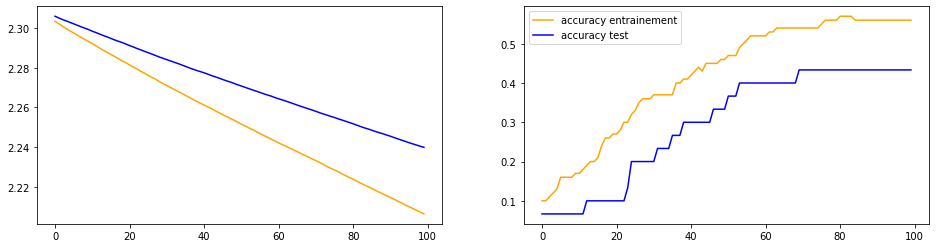

In [16]:


NBR_IT = 100
epochs = range(NBR_IT)

input_shape = (28, 28, 1)

detect_basic = Sequential()
detect_basic.add(Dense(128, activation="relu", input_shape=input_shape))
detect_basic.add(Flatten())
detect_basic.add(Dense(10, activation="softmax"))

detect_basic.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adadelta(),
    metrics=["accuracy"])

print("entrainement ...")
results = detect_basic.fit(x_train, y_train_onehot, epochs=NBR_IT, validation_data=(x_test, y_test_onehot), verbose=0)
# print("evaluation ...")
# score = detect_basic.evaluate(x_test, y_test_onehot, verbose=0)

history = results.history
couts_train = history["loss"]
couts_test = history["val_loss"]
accuracy_train = history["accuracy"]
accuracy_test = history["val_accuracy"]
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
ax[0].plot(epochs, couts_train, color="orange", label="cout entrainement")
ax[0].plot(epochs, couts_test, color="blue", label="cout test")
ax[1].plot(epochs, accuracy_train, color="orange", label="accuracy entrainement")
ax[1].plot(epochs, accuracy_test, color="blue", label="accuracy test")
plt.legend()
plt.show()

entrainement ...


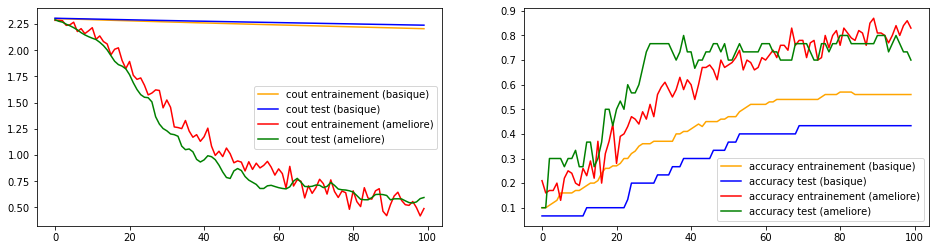

In [37]:
from tensorflow.keras import initializers

# TODO amélioer le modèle du classement de chiffres
# =============== Modifier ici ===================
xavier_initializer = tf.keras.initializers.GlorotNormal()
dropout_rate = 0.5

detect_good = Sequential()
detect_good.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer=xavier_initializer, input_shape=(28, 28, 1)))
detect_good.add(MaxPooling2D((2, 2)))
detect_good.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer=xavier_initializer, input_shape=(28, 28, 1)))
detect_good.add(MaxPooling2D((2, 2)))
detect_good.add(Flatten())
detect_good.add(Dropout(dropout_rate))
detect_good.add(Dense(32, activation="relu", input_shape=input_shape, kernel_initializer=xavier_initializer))
detect_good.add(Dropout(dropout_rate))
detect_good.add(Dense(32, activation="relu", kernel_initializer=xavier_initializer))

detect_good.add(Flatten())
detect_good.add(Dense(10, activation="softmax"))

detect_good.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer='adam',
    metrics=["accuracy"])
# =============== Fin modification ================


print("entrainement ...")
results = detect_good.fit(x_train, y_train_onehot, epochs=NBR_IT, validation_data=(x_test, y_test_onehot), verbose=0)
# print("evaluation ...")
# score = detect_basic.evaluate(x_test, y_test_onehot, verbose=0)

history = results.history

couts_train2 = history["loss"]
couts_test2 = history["val_loss"]
accuracy_train2 = history["accuracy"]
accuracy_test2 = history["val_accuracy"]
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
ax[0].plot(epochs, couts_train, color="orange", label="cout entrainement (basique)")
ax[0].plot(epochs, couts_test, color="blue", label="cout test (basique)")
ax[0].plot(epochs, couts_train2, color="red", label="cout entrainement (ameliore)")
ax[0].plot(epochs, couts_test2, color="green", label="cout test (ameliore)")
ax[0].legend()
ax[1].plot(epochs, accuracy_train, color="orange", label="accuracy entrainement (basique)")
ax[1].plot(epochs, accuracy_test, color="blue", label="accuracy test (basique)")
ax[1].plot(epochs, accuracy_train2, color="red", label="accuracy entrainement (ameliore)")
ax[1].plot(epochs, accuracy_test2, color="green", label="accuracy test (ameliore)")
ax[1].legend()
plt.show()

### II-2- Débruitage des images

Ici, on va implémenter un autoencodeur qui a comme but de débruiter les images. 
Tout d'abord, on ajoute du bruit aux images. Ensuite, l'autoencodeur est entraîné sur les images bruitées en entrée et leurs équivalentes non bruitées en sortie. 

Un modèle de base est fourni. Vous devez modifier ce modèle pour avoir un autre meilleur. Ceci en ajoutant des couches, en supprimant des couches et en modifiant les paramètres comme le nombre des neurones, etc.

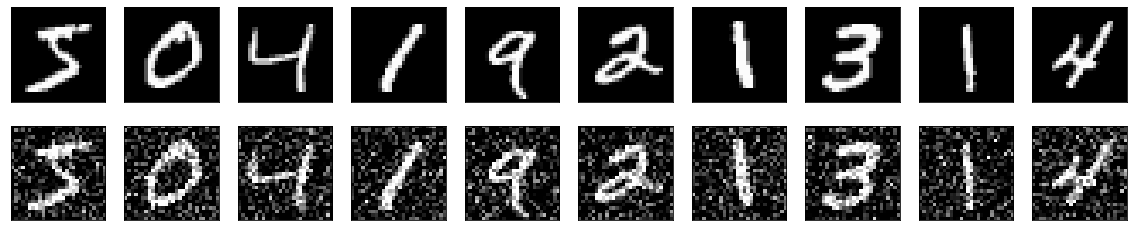

In [9]:
# Créer les images bruitées
noise_factor = 0.3
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_train_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### II-2-1- Modèle de base 

**Ne modifier pas ça**

entrainement (basic) ...


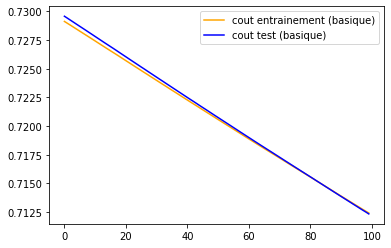

In [10]:

NBR_IT_ae = 100
epochs_ae = range(NBR_IT_ae)

input_img = Input(shape=(28, 28, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

bruit_basic = Model(input_img, decoded)
bruit_basic.compile(optimizer='adadelta', loss='binary_crossentropy')



print("entrainement (basic) ...")
results = bruit_basic.fit(x_train_noisy, x_train,
                epochs=NBR_IT_ae,
                validation_data=(x_test_noisy, x_test),
                verbose=0
                )
x_decoded = bruit_basic.predict(x_test_noisy)
history = results.history
couts_train = history["loss"]
couts_test = history["val_loss"]


plt.plot(epochs, couts_train, color="orange", label="cout entrainement (basique)")
plt.plot(epochs, couts_test, color="blue", label="cout test (basique)")
plt.legend()
plt.show()

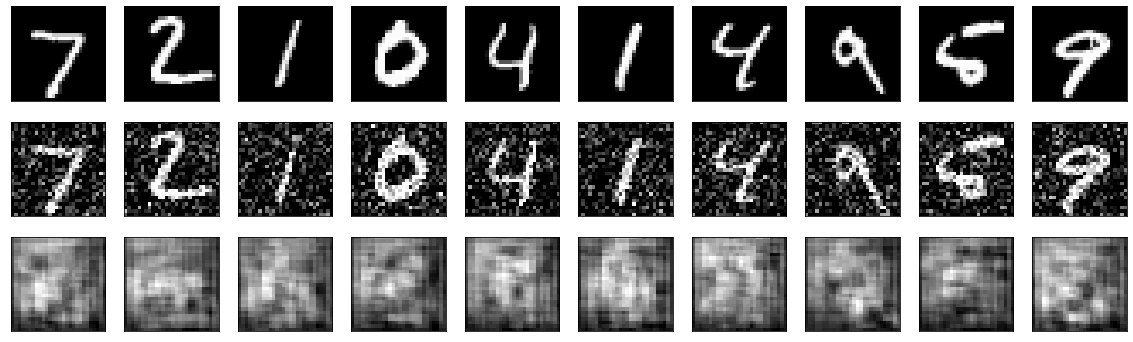

In [11]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 6))
for i in range(n):
    # image original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # image bruitée
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # image débruitée
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(x_decoded[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### II-2-2- Modèle amélioré 

**Modifier ici**

entrainement (ameliore) ...


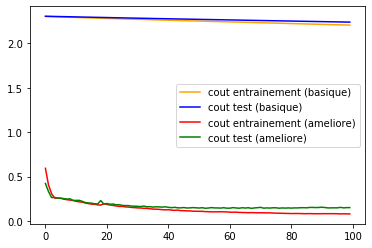

In [33]:
# TODO améliorer le modèle du débruitage des images
# =============== Modifier ici ===================

input_img2 = Input(shape=(28, 28, 1))

# Encoding #

x2 = Conv2D(filters = 256, kernel_size = (3, 3), activation='relu', padding='same')(input_img2)
x2 = MaxPooling2D(pool_size = (2, 2), padding='same')(x2)

x2 = Conv2D(filters = 128, kernel_size = (3, 3), activation='relu', padding='same')(x2)
x2 = MaxPooling2D(pool_size = (2, 2), padding='same')(x2) 

x2 = Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', padding='same')(x2)
encoded2 = MaxPooling2D(pool_size = (2, 2), padding='same')(x2)

# Decoding #

x2 = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded2)
x2 = UpSampling2D((2, 2))(x2)

x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x2)
x2 = UpSampling2D((2, 2))(x2)

x2 = Conv2D(256, (3, 3), activation='relu')(x2)
x2 = UpSampling2D((2, 2))(x2)

decoded2 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x2)

bruit_good = Model(input_img2, decoded2)
bruit_good.compile(optimizer='adam', loss='binary_crossentropy')
# =============== Fin modification ================

print("entrainement (ameliore) ...")
results = bruit_good.fit(x_train_noisy, x_train,
                epochs=NBR_IT_ae,
                validation_data=(x_test_noisy, x_test),
                verbose=0
                )
x_decoded2 = bruit_good.predict(x_test_noisy)
history = results.history
couts_train2 = history["loss"]
couts_test2 = history["val_loss"]

plt.plot(epochs, couts_train, color="orange", label="cout entrainement (basique)")
plt.plot(epochs, couts_test, color="blue", label="cout test (basique)")
plt.plot(epochs, couts_train2, color="red", label="cout entrainement (ameliore)")
plt.plot(epochs, couts_test2, color="green", label="cout test (ameliore)")
plt.legend()
plt.show()

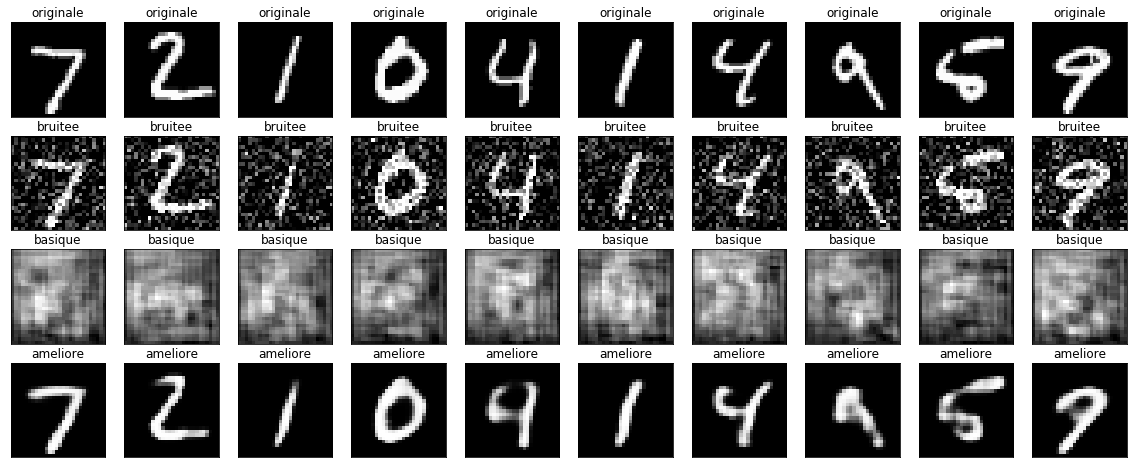

In [34]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 8))
for i in range(n):
    # image original
    ax = plt.subplot(4, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("originale")
    
    # image bruitée
    ax = plt.subplot(4, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("bruitee")

    # image débruitée (basique)
    ax = plt.subplot(4, n, i + 1 + 2 * n)
    plt.imshow(x_decoded[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("basique")
    
    # image débruitée (amélioré)
    ax = plt.subplot(4, n, i + 1 + 3 * n)
    plt.imshow(x_decoded2[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("ameliore")
    
plt.show()